**The problem with modeling long sequences**
Translating a text word by word isn't feasible due to the differences in grammatical structures between the source and target languages:*

Through an attention mechanism, the text-generating decoder segment of the network is capable of selectively accessing all input tokens, implying that certain input tokens hold more significance than others in the generation of a specific output token

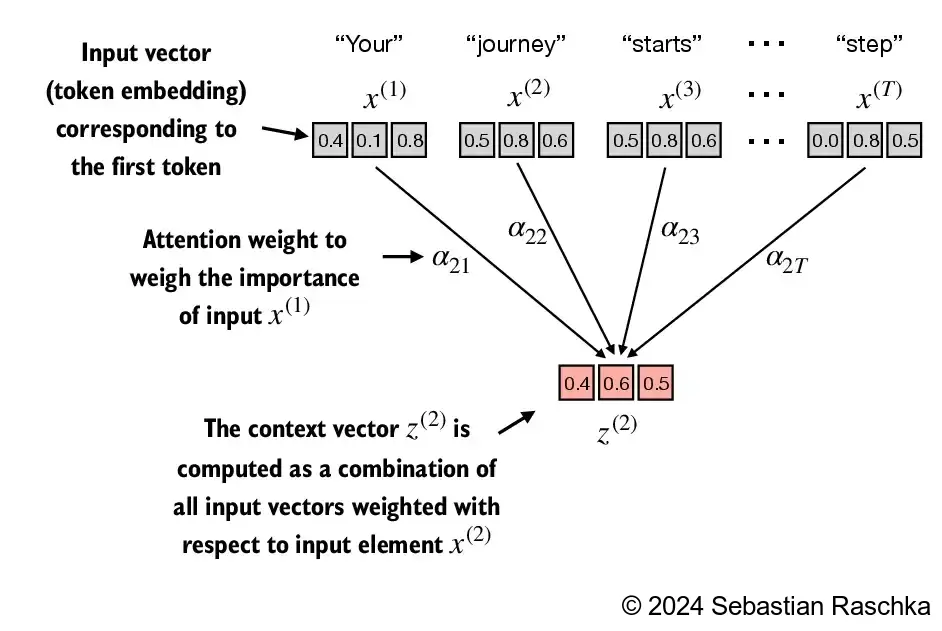

In [61]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [62]:
torch.dot(inputs[1], inputs[2]) # dot product (transpose not necessary here since they are 1-dim vectors)

tensor(1.4754)

In [63]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [64]:
res = 0.

for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]

print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


normalize the unnormalized attention scores ("omegas",
) so that they sum up to 1

In [65]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended.

In [66]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [67]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [68]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


**Computing attention weights for all input tokens**

we are generalizing this computation to compute all attention weights and context vectors

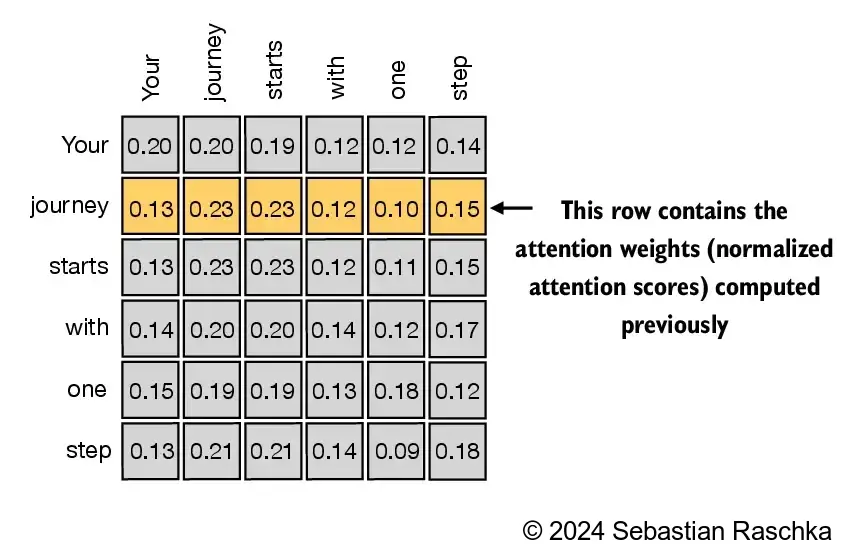

In [69]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [70]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [71]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [72]:
torch.sum(attn_weights[1])

tensor(1.)

In [73]:
all_context_vecs = attn_weights @ inputs
all_context_vecs

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

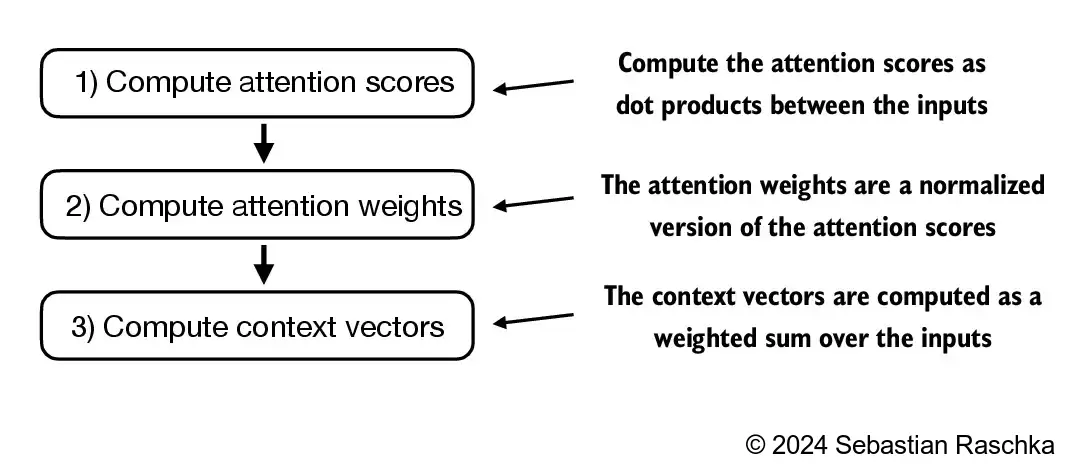

# Self Attention with trainable weights

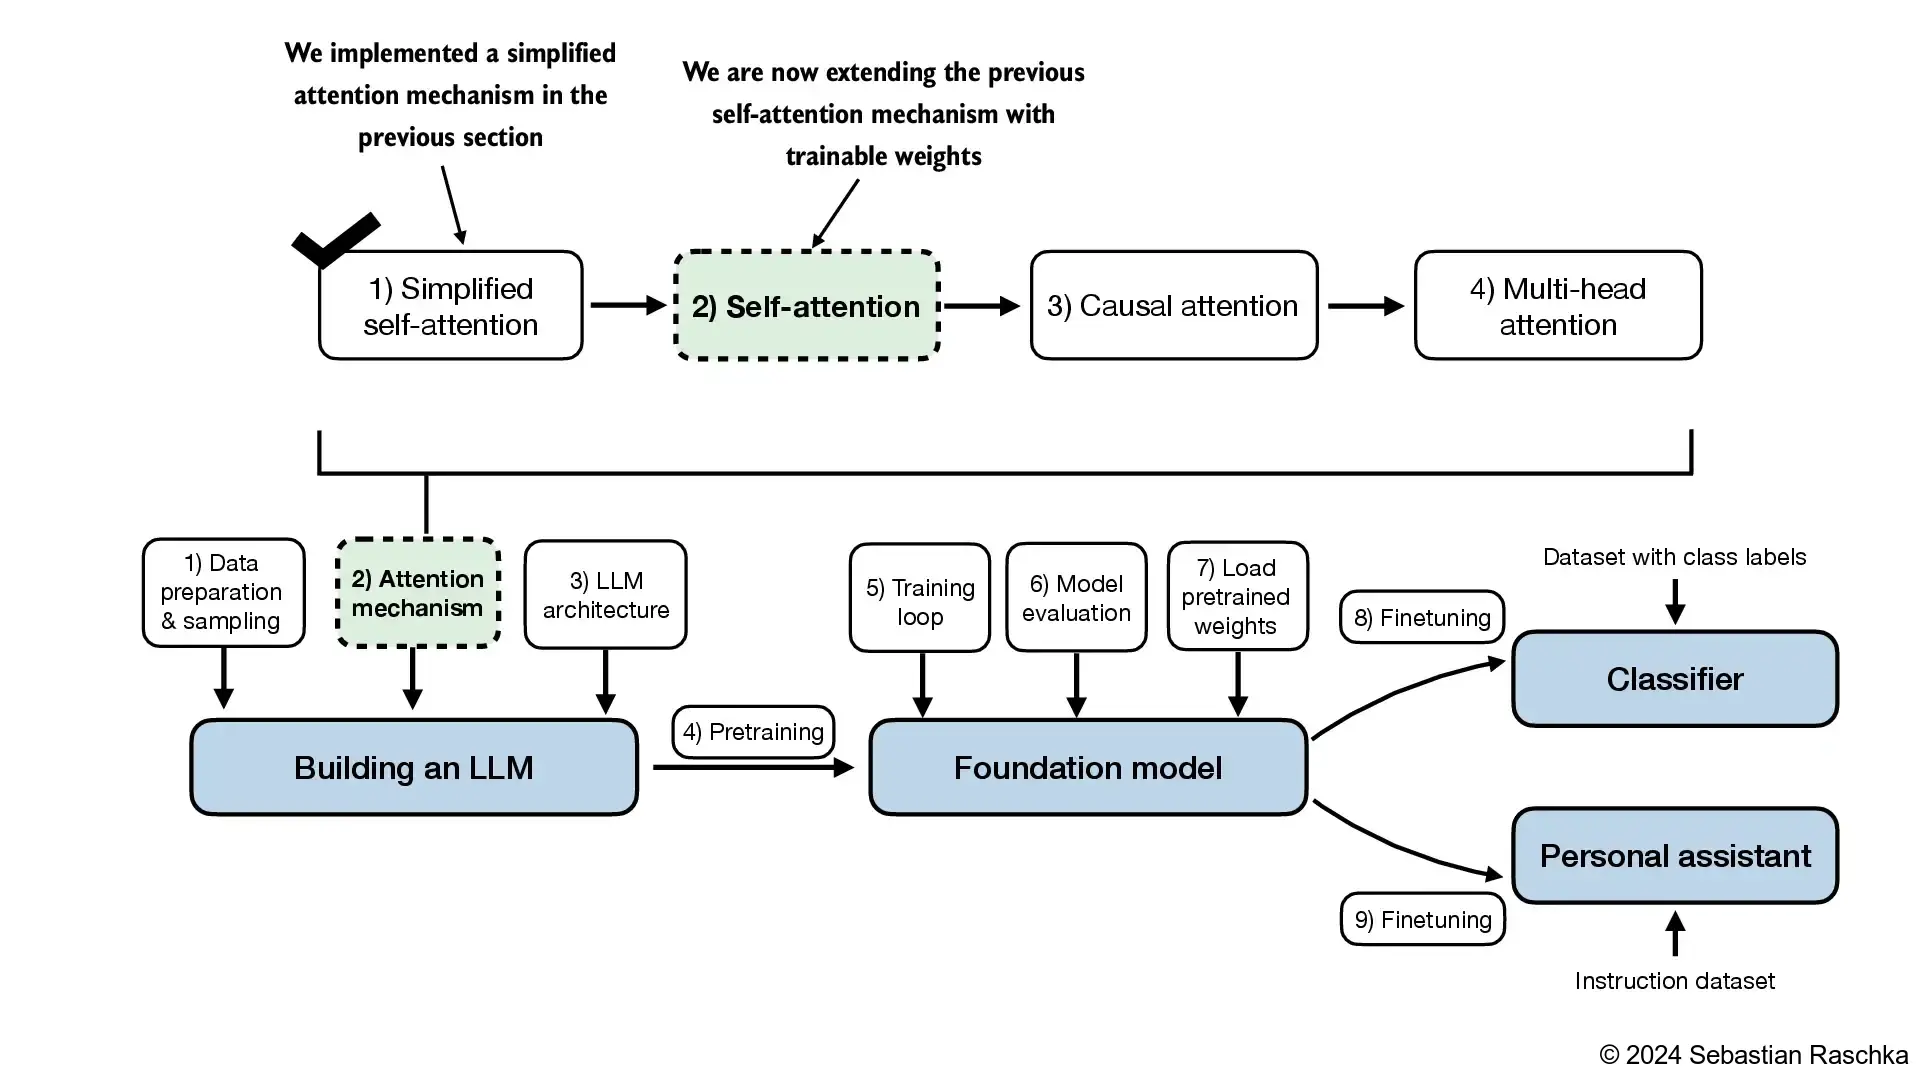

 we are implementing the self-attention mechanism that is used in the original transformer architecture, the GPT models, and most other popular LLMs
This self-attention mechanism is also called "scaled dot-product attention"

In [74]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

**Trainable Weights**

**What is Self-Attention with Trainable Weights?**
Self-attention allows a model to weigh the importance of different tokens in a sequence when processing each token. In the scaled dot-product attention mechanism, this is achieved by transforming input embeddings into `query, key, and value vectors` using trainable weight matrices. These weights are learned during training to optimize how the model attends to different parts of the input sequence.

The document provides a practical example with a small input tensor and demonstrates how these weight matrices are applied.

In [75]:
x_2 = inputs[1]
d_in = inputs.shape[1] #input embedding size , d = 3
d_out = 2

print("d_in : ",d_in)
print("d_out : ",d_out)

d_in :  3
d_out :  2


**Trainable Weight Matrices:**
Three weight matrices are defined: `W_query, W_key, and W_value`, each of shape `[d_in, d_out]` (i.e., `[3, 2]` in this case).
These matrices are initialized randomly and marked as `requires_grad=False` in the example for simplicity (in a real model, they would be trainable, i.e., `requires_grad=True`).


Visualizing the Role of Trainable Weights
To help visualize, imagine the self-attention mechanism as a process where:


```
Query: Asks, “What am I looking for in the sequence?”
```

```
Key: Responds, “Here’s what each token represents.”
```
```
Value: Provides, “Here’s the information to retrieve if this token is relevant.”
```

The trainable weights shape these questions and answers by learning to project the input embeddings into a space where relevant tokens align closely (via high dot-product scores).

**Trainable Weight Matrices:**

In [76]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in,d_out),requires_grad=False)

In [77]:
W_query

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])

The weights `(W_query, W_key, W_value)` are initialized randomly or using techniques like Xavier initialization to ensure stable training.
In the document, `torch.rand` is used for simplicity, but in practice, these are parameters of a neural network layer (e.g., `torch.nn.Linear`).

In [78]:
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

**Computing Query, Key, and Value Vectors**

For each token, the input embedding (e.g., x_2 of shape `[3]`) is multiplied by W_query (shape `[3, 2]`) to produce a query vector of shape `[2]`. The same applies to keys and values.

In [79]:
print("x_2 : ",x_2)
print("\nW_query : ",W_query)
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
print("\nquery_2 : ",query_2)

x_2 :  tensor([0.5500, 0.8700, 0.6600])

W_query :  Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])

query_2 :  tensor([0.4433, 1.1419])


In [80]:
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

Both keys and values have shape `[6, 2]`, as there are 6 tokens, each projected to a 2D vector.

# vector of value and the key

In [81]:
keys = inputs @ W_key
values = inputs @ W_value
keys

tensor([[0.1855, 0.8812],
        [0.3951, 1.0037],
        [0.3879, 0.9831],
        [0.2393, 0.5493],
        [0.1492, 0.3346],
        [0.3221, 0.7863]])

In [82]:
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


**Compute Unnormalized Attention Scores**

The dot product `query_2.dot(keys_2)` computes the similarity between the query and key for the second token, resulting in a `scalar: 1.3213`
This score reflects how much the second token “attends” to itself.

In [83]:
keys_2 = keys[1] # Python starts index at 0
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.3213)


**Computing Scores for All Tokens**

In [84]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.0884, 1.3213, 1.2945, 0.7333, 0.4482, 1.0406])


In [85]:
m = (inputs@W_query)@keys.T
m[1]

tensor([1.0884, 1.3213, 1.2945, 0.7333, 0.4482, 1.0406])

**Compute Attention Weights (Normalized Scores)**

In [86]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1749, 0.2062, 0.2024, 0.1361, 0.1112, 0.1691])


**Compute the Context Vector**

The `attention weights are used to compute a context vector`, which is a weighted sum of the value vectors. This context vector represents the `information the model gathers from the input sequence for the second token.`

In [87]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([1.0557, 1.2108])



### Attention Workflow for the Second Token

## **Input Vector**
```
x_2 = [0.5500, 0.8700, 0.6600]  (shape: [3])
````

### **Query, Key, and Value Vectors**

```plaintext
query_2 = x_2 @ W_query = [0.4433, 1.1419]  (shape: [2])
keys = inputs @ W_key                  (shape: [6, 2])
values = inputs @ W_value              (shape: [6, 2])
```

### **Unnormalized Attention Scores**

```plaintext
attn_scores_2 = query_2 @ keys.T = [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440]  (shape: [6])
```

### **Normalized Attention Weights**

* **Scale**:

  ```plaintext
  attn_scores_2 / sqrt(2)
  ```

* **Softmax**:
  ```plaintext
  attn_weights_2 = softmax(attn_scores_2 / sqrt(2))
                 = [0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820]  (shape: [6])
  ```

### **Context Vector**

```plaintext
context_vec_2 = attn_weights_2 @ values = [0.3061, 0.8210]  (shape: [2])
```

##Implementing a compact SelfAttention class

In [88]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):
  def __init__(self,d_in,d_out):
    super().__init__()
    self.W_query = nn.Parameter(torch.rand(d_in,d_out))
    self.W_key = nn.Parameter(torch.rand(d_in,d_out))
    self.W_value = nn.Parameter(torch.rand(d_in,d_out))

  def forward(self,x):
    # vectors
    keys = x@self.W_key
    values = x@self.W_value
    query = x@self.W_query

    # attention score
    attn_scores = query@keys.T
    # attention weight (normalized attention score)
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

    # context vector
    context_vec = attn_weights@values
    return context_vec

In [89]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


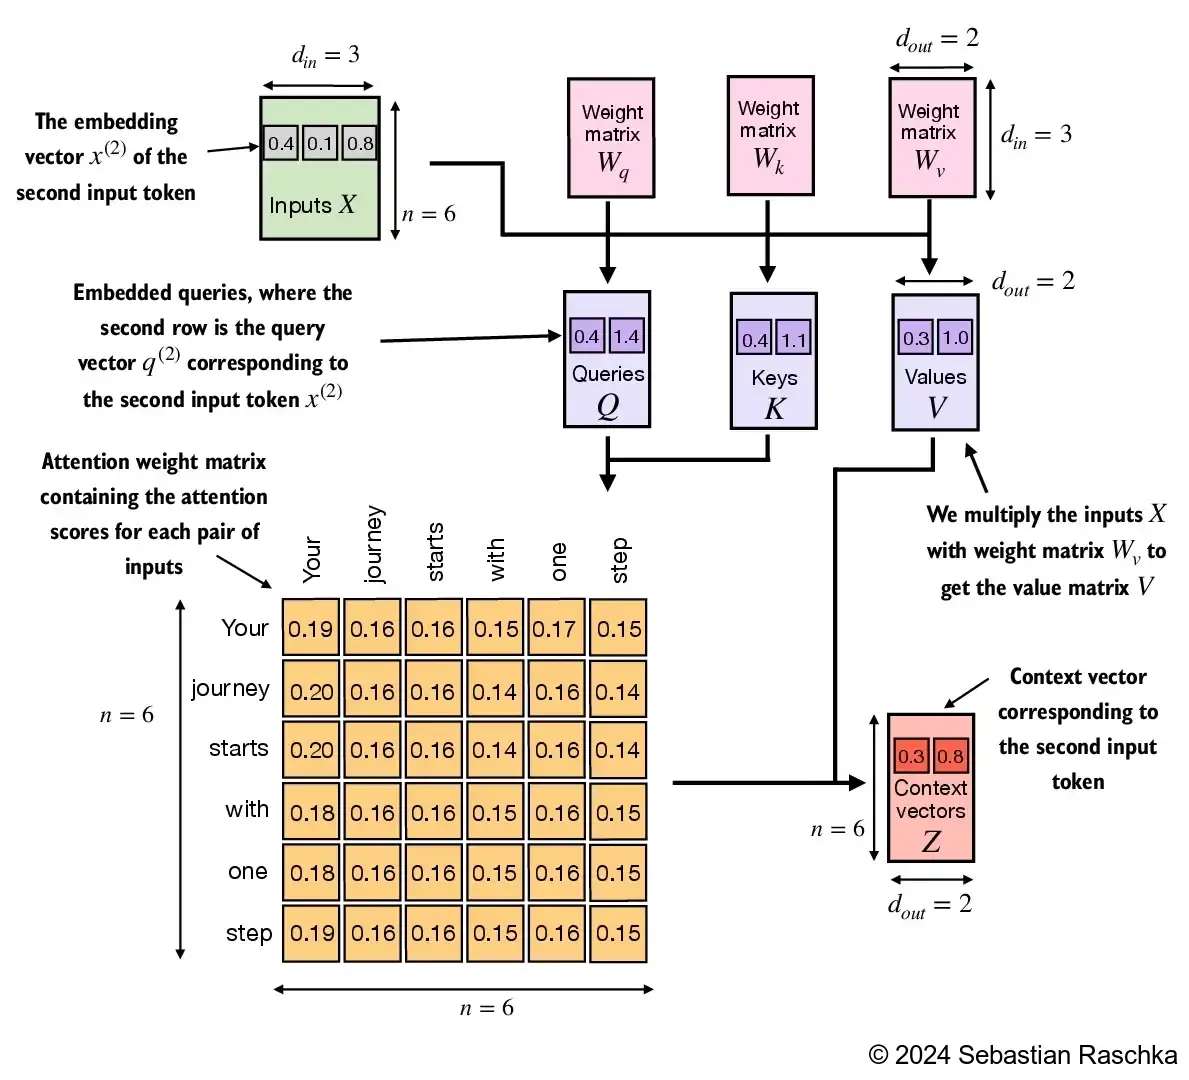

 big advantage of using nn.Linear over our manual nn.Parameter(`torch.rand(...)` approach is that nn.Linear has a preferred weight initialization scheme, which leads to more stable model training

In [90]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


Note that `SelfAttention_v1` and `SelfAttention_v2` give different outputs because they use different initial weights for the weight matrices

**Hiding future words with causal attention**

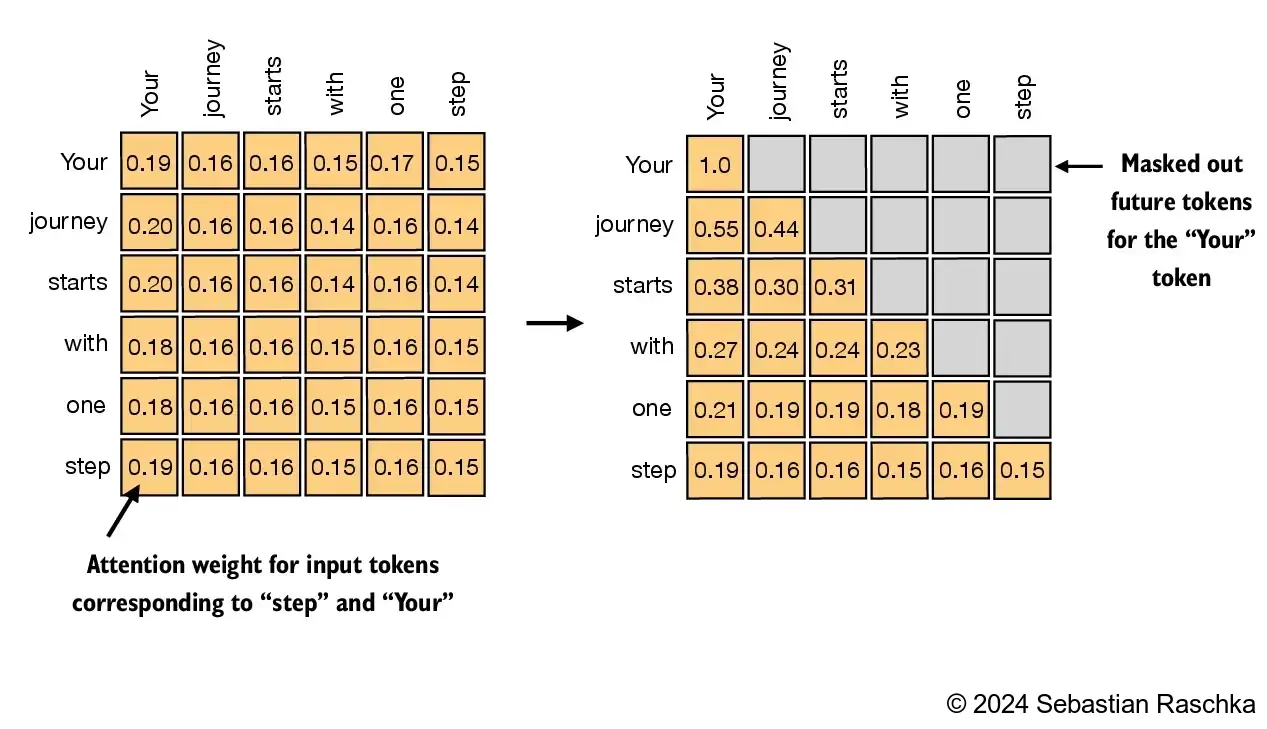

**Applying a causal attention mask**
In this section, we are converting the previous self-attention mechanism into a causal self-attention mechanism
Causal self-attention ensures that the model's prediction for a certain position in a sequence is only dependent on the known outputs at previous positions, not on future positions
In simpler words, this ensures that each next word prediction should only depend on the preceding words
To achieve this, for each given token, we mask out the future tokens (the ones that come after the current token in the input text):


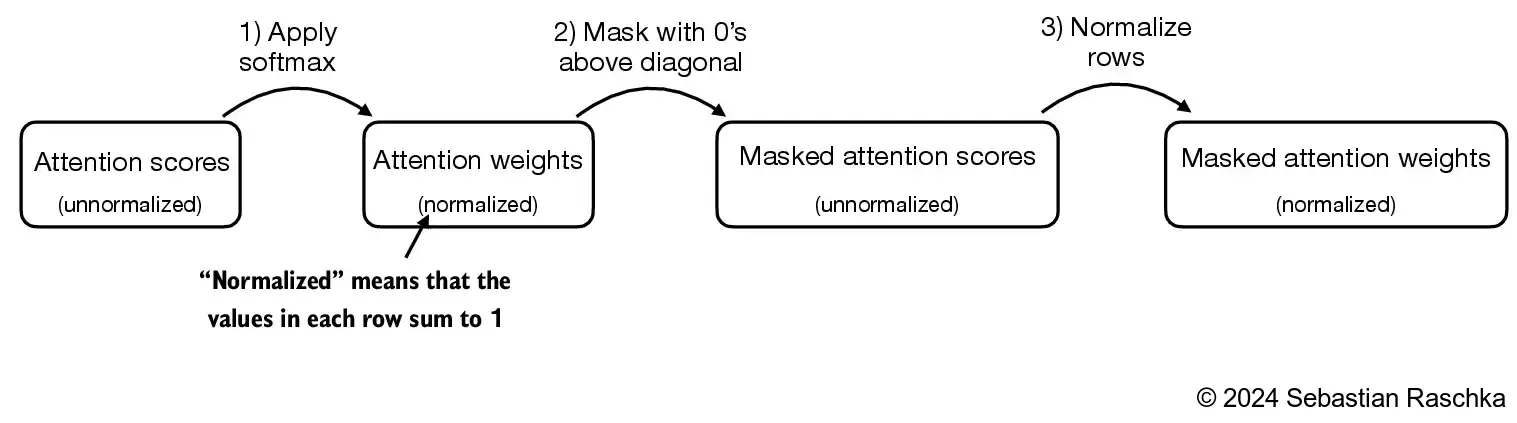

In [91]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the previous section for convenience
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


The simplest way to mask out future attention weights is by creating a mask via PyTorch's tril function with elements below the main diagonal (including the diagonal itself) set to 1 and above the main diagonal set to 0:

In [92]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Then, we can multiply the attention weights with this mask to zero out the attention scores above the diagonal:

In [93]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


nstead of zeroing out attention weights above the diagonal and renormalizing the results, we can mask the unnormalized attention scores above the diagonal with negative infinity before they enter the softmax function:

In [94]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


**Masking additional attention weights with dropout**


```
# we apply dropout to reduce overfitting during training
```



**Dropout can be applied in several places:**
for example, after computing the attention weights;
or after multiplying the attention weights with the value vectors
Here, we will apply the dropout mask after computing the attention weights because it's more common

Furthermore, in this specific example, we use a dropout rate of 50%, which means randomly masking out half of the attention weights. (When we train the GPT model later, we will use a lower dropout rate, such as 0.1 or 0.2

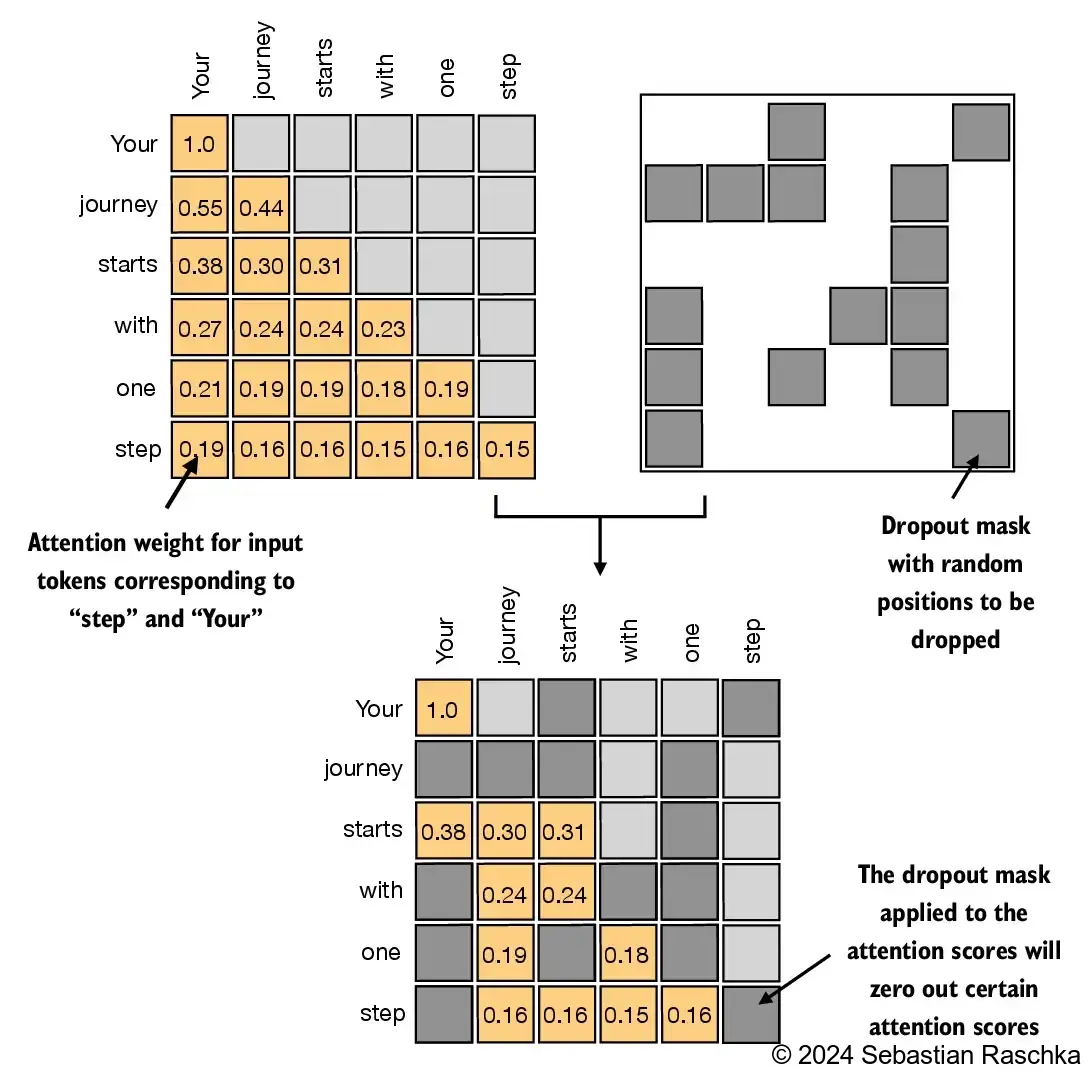

If we apply a dropout rate of `0.5 (50%)`, the non-dropped values will be scaled accordingly by a factor of `1/0.5 = 2`
The scaling is calculated by the formula `1 / (1 - dropout_rate)`

In [95]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [96]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[0.3843, 0.3293, 0.3303, 0.3100, 0.3442, 0.3019],
        [0.0000, 0.3318, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3325, 0.0000, 0.3328, 0.0000],
        [0.3738, 0.3334, 0.0000, 0.0000, 0.0000, 0.3128],
        [0.3661, 0.0000, 0.0000, 0.0000, 0.0000, 0.3169],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


**Implementing a compact causal self-attention class**

In [97]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

torch.Size([2, 6, 3])


In [98]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        # For inputs where `num_tokens` exceeds `context_length`, this will result in errors
        # in the mask creation further below.
        # In practice, this is not a problem since the LLM (chapters 4-7) ensures that inputs
        # do not exceed `context_length` before reaching this forward method.
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


Note that dropout is only applied during training, not during inference

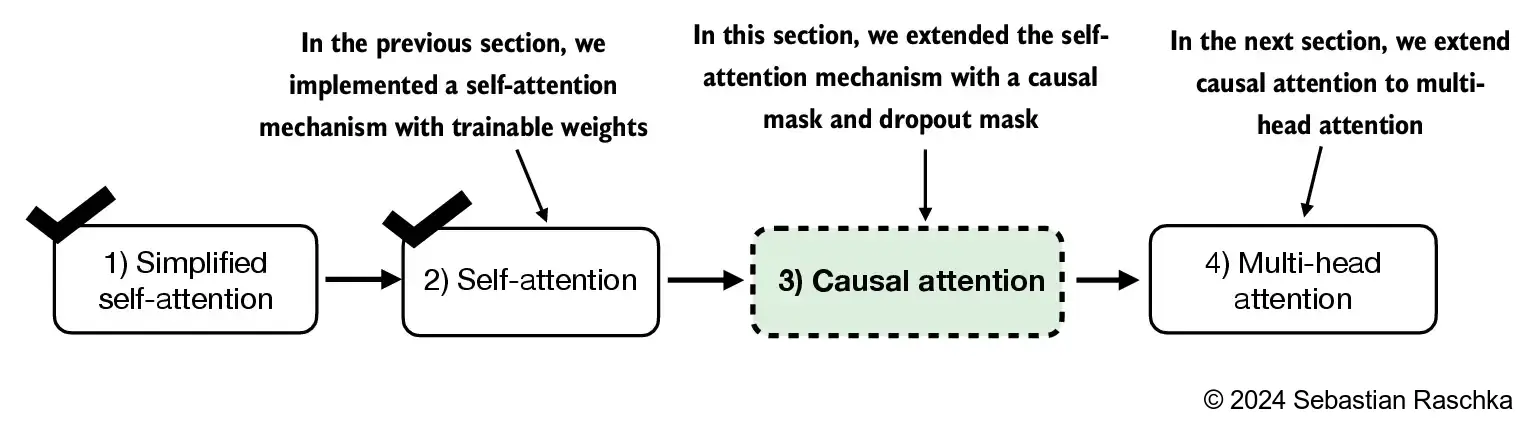

## Extending single-head attention to multi-head attention

## Stacking multiple single-head attention layers

This is also called single-head attention:

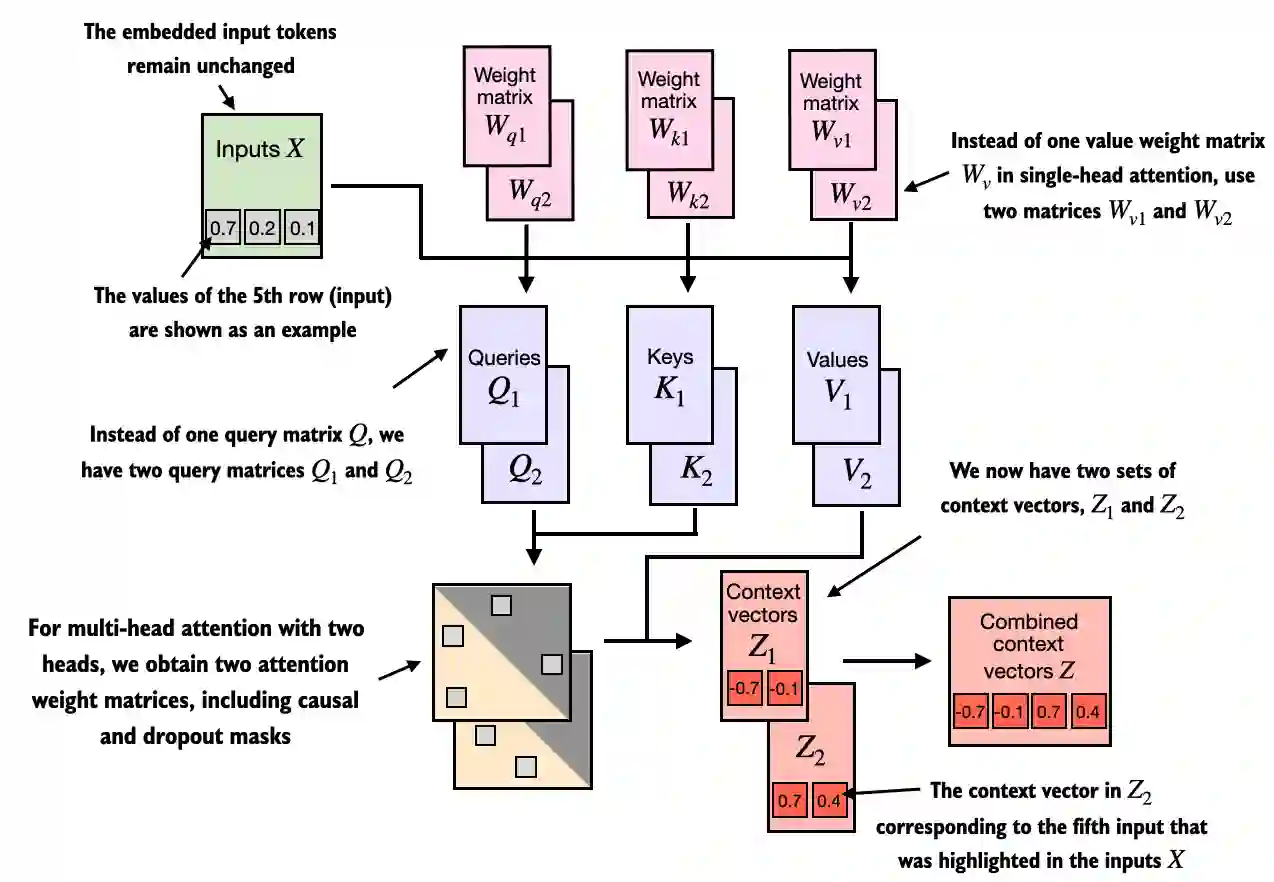

We simply stack multiple single-head attention modules to obtain a multi-head attention module:


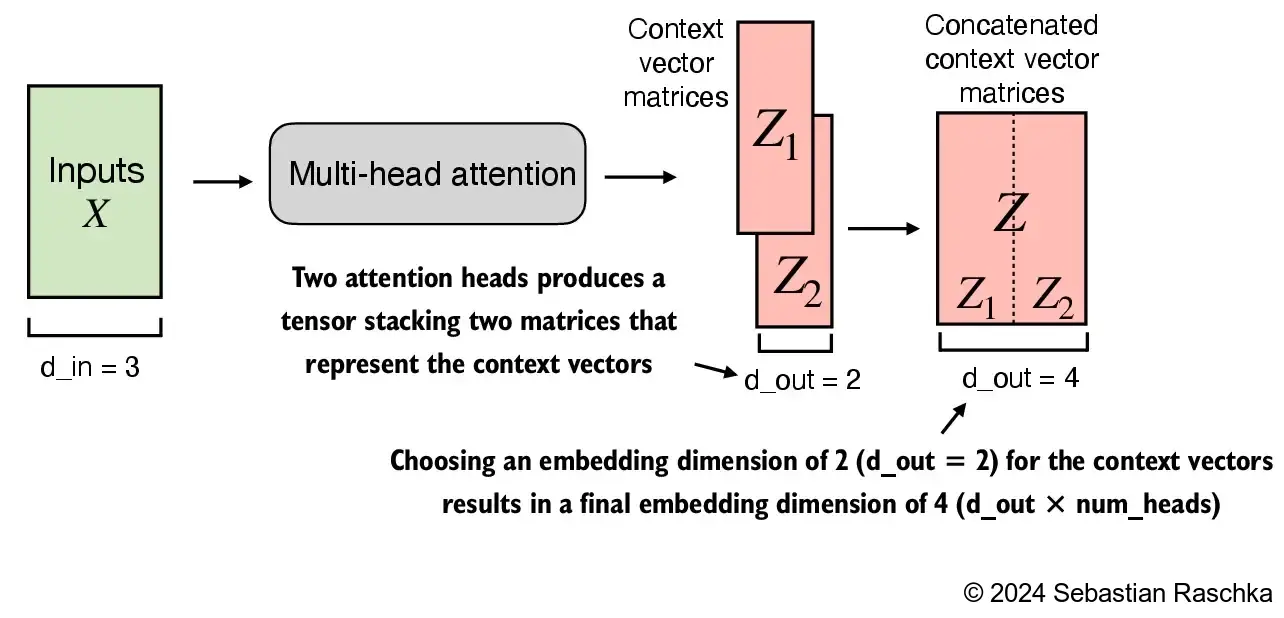

The main idea behind multi-head attention is to run the attention mechanism multiple times (in parallel) with different, learned linear projections. This allows the model to jointly attend to information from different representation subspaces at different positions.

In [99]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)


torch.manual_seed(123)

context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

torch.Size([2, 6, 3])
tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


In the implementation above, the embedding dimension is 4, because we d_out=2 as the embedding dimension for the key, query, and value vectors as well as the context vector. And since we have 2 attention heads, we have the output embedding dimension 2*2=4


**Implementing multi-head attention with weight splits**
While the above is an intuitive and fully functional implementation of multi-head attention (wrapping the single-head attention CausalAttention implementation from earlier), we can write a stand-alone class called MultiHeadAttention to achieve the same

We don't concatenate single attention heads for this stand-alone MultiHeadAttention class

Instead, we create single `W_query, W_key, and W_value` weight matrices and then split those into individual matrices for each attention head:

In [100]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # As in `CausalAttention`, for inputs where `num_tokens` exceeds `context_length`,
        # this will result in errors in the mask creation further below.
        # In practice, this is not a problem since the LLM (chapters 4-7) ensures that inputs
        # do not exceed `context_length` before reaching this forwar

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


Note that the above is essentially a rewritten version of MultiHeadAttentionWrapper that is more efficient
The resulting output looks a bit different since the random weight initializations differ, but both are fully functional implementations that can be used in the GPT class we will implement in the upcoming chapters
Note that in addition, we added a linear projection layer (self.out_proj ) to the MultiHeadAttention class above. This is simply a linear transformation that doesn't change the dimensions. It's a standard convention to use such a projection layer in LLM implementation, but it's not strictly necessary (recent research has shown that it can be removed without affecting the modeling performance; see the further reading section at the end of this chapter)

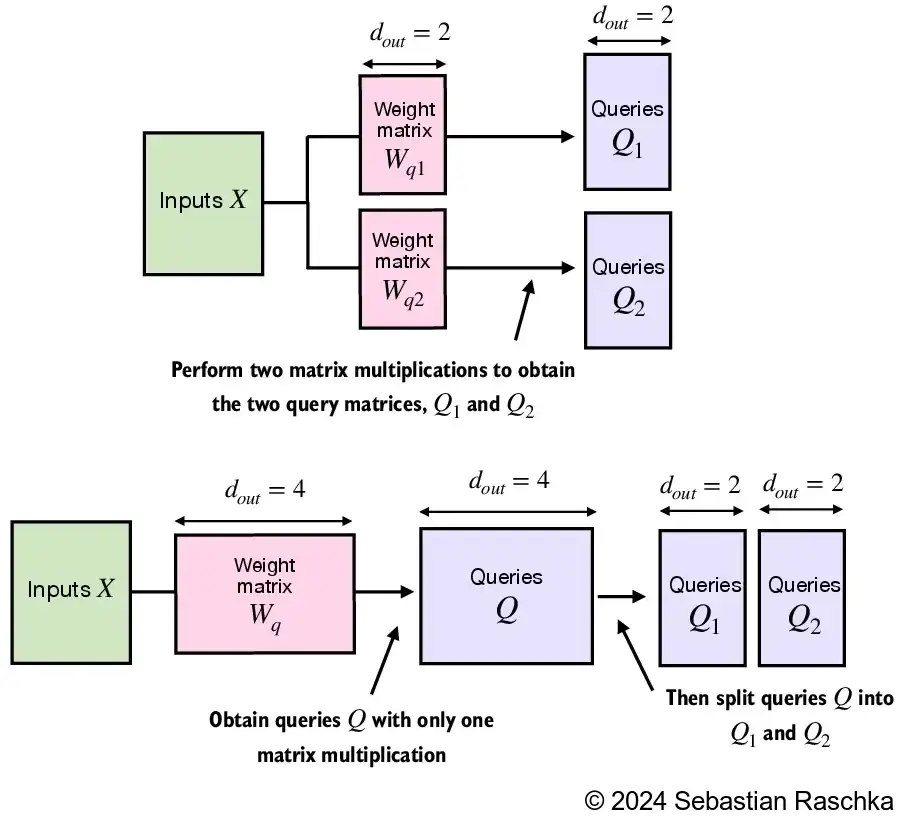

Note that if you are interested in a compact and efficient implementation of the above, you can also consider the torch.nn.MultiheadAttention class in PyTorch
Since the above implementation may look a bit complex at first glance, let's look at what happens when executing attn_scores = queries @ keys.transpose(2, 3):

In [101]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In this case, the matrix multiplication implementation in PyTorch will handle the 4-dimensional input tensor so that the matrix multiplication is carried out between the 2 last dimensions (num_tokens, head_dim) and then repeated for the individual heads

For instance, the following becomes a more compact way to compute the matrix multiplication for each head separately:

In [102]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])
